In [101]:
import pandas as pd
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore")

import string
import nltk
from nltk import word_tokenize, FreqDist, SnowballStemmer, pos_tag
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier

In [102]:
data = pd.read_csv('Wish Summer Product Data.csv')
#data.head()
data.shape

(1573, 43)

In [ ]:
data.columns

Index(['title', 'title_orig', 'price', 'retail_price', 'currency_buyer',
       'units_sold', 'uses_ad_boosts', 'rating', 'rating_count',
       'rating_five_count', 'rating_four_count', 'rating_three_count',
       'rating_two_count', 'rating_one_count', 'badges_count',
       'badge_local_product', 'badge_product_quality', 'badge_fast_shipping',
       'tags', 'product_color', 'product_variation_size_id',
       'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'urgency_text',
       'origin_country', 'merchant_title', 'merchant_name',
       'merchant_info_subtitle', 'merchant_rating_count', 'merchant_rating',
       'merchant_id', 'merchant_has_profile_picture',
       'merchant_profile_picture', 'product_url', 'product_picture',
       'product_id', 'theme', 'crawl_month'],
      dtype='object')

In [ ]:
data.isna().sum()

title                              0
title_orig                         0
price                              0
retail_price                       0
currency_buyer                     0
units_sold                         0
uses_ad_boosts                     0
rating                             0
rating_count                       0
rating_five_count                 45
rating_four_count                 45
rating_three_count                45
rating_two_count                  45
rating_one_count                  45
badges_count                       0
badge_local_product                0
badge_product_quality              0
badge_fast_shipping                0
tags                               0
product_color                     41
product_variation_size_id         14
product_variation_inventory        0
shipping_option_name               0
shipping_option_price              0
shipping_is_express                0
countries_shipped_to               0
inventory_total                    0
h

# Data Pre-processing

In [ ]:
# Since the following features have no impact on the data analysis, remove them initially 
to_drop = ['product_variation_size_id', 'product_variation_inventory', 'shipping_option_name', 'countries_shipped_to','urgency_text',
          'origin_country', 'merchant_title', 'merchant_name','merchant_info_subtitle', 'merchant_id',
           'product_id', 'theme', 'crawl_month', 'currency_buyer']
data = data.drop(columns= to_drop)

In [ ]:
data.shape

(1573, 29)

In [ ]:
# All the rating_NO._count columns has as many missing values
# It is necessary to explore their relationship with the associated rating_count column(no missing values) 
# to know what to do with them

print(data.loc[data['rating_one_count'].isna(),'rating_count'].value_counts())
print(data.loc[data['rating_five_count'].isna(),'rating_count'].value_counts())

# All values in the rating_count column are 0 where there are NA values in rating_NO._count columns

0    45
Name: rating_count, dtype: int64
0    45
Name: rating_count, dtype: int64


In [ ]:
#So the missing values in rating_NO._count columns should be replaced by 0
rating_number_columns = ['rating_one_count','rating_two_count','rating_three_count',
                  'rating_four_count','rating_five_count']
data[rating_number_columns] = data[rating_number_columns].fillna(value = 0)

In [103]:
data['units_sold'].value_counts()

100       509
1000      405
5000      217
10000     177
20000     103
50         76
10         49
50000      17
100000      6
8           4
1           3
7           2
3           2
2           2
6           1
Name: units_sold, dtype: int64

In [ ]:
# Since the amount of data for units_sold less than 10 is very small
# Delete the rows for units_sold less than 10 to unify the data level
data = data[~(data['units_sold']<10)]
data['units_sold'].unique()

array([   100,  20000,   5000,     10,  50000,   1000,  10000, 100000,
           50])

In [ ]:
data['has_urgency_banner'].unique()
# Judging from the definition，this column should be binary.

array([ 1., nan])

In [ ]:
data['has_urgency_banner'] = data['has_urgency_banner'].fillna(value = 0)
data['has_urgency_banner'].unique()

array([1., 0.])

In [ ]:
dup=data.duplicated()
sum(dup)

33

In [ ]:
data = data.drop_duplicates()
data.shape

(1526, 29)

In [ ]:
# Creat new feature 'discount'
data['discount'] = (data['retail_price'] - data['price'])/data['retail_price']*100

In [ ]:
#Since discount can represent the relationship of retail_price and price,keep only one of them is enough
#Price is the information that customers see directly, so we choose to keep it as representation
data.drop(columns = 'retail_price', inplace = True)

In [ ]:
for colname in data.columns:
    if data[colname].isnull().any()==True:
        print(colname)
# There are still two columns which have null values. They will be dealt with later

product_color
merchant_profile_picture


In [ ]:
#Now we deal with outliers
#Find out features that are not binary first
describe = data.describe().T
non_binary_col_names =describe.loc[data.nunique()!=2].index.tolist()
non_binary_col = data[non_binary_col_names]
non_binary_col_names

['price',
 'units_sold',
 'rating',
 'rating_count',
 'rating_five_count',
 'rating_four_count',
 'rating_three_count',
 'rating_two_count',
 'rating_one_count',
 'badges_count',
 'shipping_option_price',
 'inventory_total',
 'merchant_rating_count',
 'merchant_rating',
 'discount']

In [ ]:
def Zscore_outlier(df):
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            outliers.append(i)
    return outliers
    
for i in range(non_binary_col.shape[1]):
    outliers=[]
    print('Unique outliers for',non_binary_col_names[i],':',set(Zscore_outlier(non_binary_col.iloc[:,i])))
    print('------------------------------------------------------------------------------------------------------------------------------')

#Judging from z-score,there are outliers for all non-binary features except discount
#However, after examniate these values, we believe that they should be reasonable, so we don't make adjustments and save them till later

Unique outliers for price : {49.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0}
------------------------------------------------------------------------------------------------------------------------------
Unique outliers for units_sold : {50000, 100000}
------------------------------------------------------------------------------------------------------------------------------
Unique outliers for rating : {1.5, 2.0, 2.25, 1.0}
------------------------------------------------------------------------------------------------------------------------------
Unique outliers for rating_count : {8960, 20744, 11913, 10122, 8971, 12041, 13198, 11408, 7575, 18463, 8609, 17444, 10150, 7596, 10927, 7088, 13488, 11062, 17980, 8904, 7753, 7242, 12880, 18393, 8412, 8029, 13789, 7773, 8164, 14568, 7022, 9330, 9075, 9207, 9337}
------------------------------------------------------------------------------------------------------------------------------
Unique outliers for rating_five_count : {4487.0, 3598.0, 5

# Data Validation

In [ ]:
#test column validity, inventory & profile pic
print(sum(data['merchant_has_profile_picture']))
print(len(data)-data['merchant_profile_picture'].isnull().sum()) #both have 225 values,see whether can accord to each other
print(data[data['merchant_has_profile_picture']==1][data['merchant_profile_picture'].isnull()==0].shape) #combined has 225 values also
#profile pic value pass validation
data.drop(columns='merchant_profile_picture',inplace=True) #delete pic url

data['inventory_total'].unique() #array([50, 40, 36,  1, 30,  2,  9, 24, 37, 38])
#there is no 0 inventory inside, inventory value pass validation

224
224
(224, 29)


array([50, 40, 36,  1, 30,  2,  9, 24, 37, 38])

# Product Color - RGB

In [ ]:
data["product_color"].value_counts() #there are 101 kinds of color, some are so detailed

black             297
white             242
yellow            100
pink               97
blue               95
                 ... 
offblack            1
brown & yellow      1
rosegold            1
lightgrey           1
lightgray           1
Name: product_color, Length: 100, dtype: int64

In [ ]:
data.loc[data["product_color"].isna(), ["product_url"]] #for those na, make up by product_url

,product_url
26,https://www.wish.com/c/5b5edbae1e222732845e655f
30,https://www.wish.com/c/5c9d920da94960780239d468
149,https://www.wish.com/c/58e0f38f9bf29f55183efd0d
216,https://www.wish.com/c/573db9316b335c34ca0513b8
284,https://www.wish.com/c/5c935aa8778e8274b0bdcead
460,https://www.wish.com/c/5e70ba09e3d51e1002f7cf8e
500,https://www.wish.com/c/569de6363e68eb0d85e0cded
547,https://www.wish.com/c/56f640b461d6cf68cb5c5d83
585,https://www.wish.com/c/59636dbdc657d57012e8b3f3
587,https://www.wish.com/c/5ac302716931da0d71398f53


In [ ]:
missing_color=['white','blue','red','purple','black','white','white','white','blue','black',
              np.nan,'black','black','black','white',np.nan,'blue','white','yellow','red',
              np.nan,'red','green','blue',np.nan,'blue','green','red','white','yellow',
              'black','white','white',np.nan,'white','green',np.nan,np.nan,'blue','blue']
assert len(missing_color) == data.loc[data["product_color"].isna(),:].shape[0], f"There are missing colors, {len(missing_color)}"
data.loc[data["product_color"].isna(), ["product_color"]] = missing_color
data.loc[data["product_color"] == "multicolor", ["product_color"]] = np.nan

In [ ]:
data["product_color"].isna().sum()

27

In [ ]:
color_mapping = {
    "coffee": "#381E07",
    "floral": "#E4A593",
    "rose": "pink",
    "leopard": "#F2D24A",
    "leopardprint": "#F2D24A",
    "camouflage": "green",
    "army": "green",
    "camel": "#C19A6B",
    "wine": "#940F22",
    "apricot": "#F3C8AB",
    "burgundy": "#7D2F3D",
    "jasper": "#D0393C",
    "claret": "#940F22",
    "rainbow": "white",
    "star": "yellow",
    "nude": "pink"
}
#sioe.cn/yingyong/yanse-rgb-16/

In [ ]:
def get_rgb(color):
    """ 
    Returns the rgb vector if the color exists on matplotlib. 
    This function is a bit messy with the nested try except statements, but performance is not critical 
    and it works for now, but I should clean it later """
    
    if color in color_mapping.keys():
        return matplotlib.colors.to_rgb(color_mapping[color])

    try:
        return matplotlib.colors.to_rgb(color)
    except:
        base_colors = ["blue", "green", "red", "white", "black", "gold", "yellow", "pink", "purple", "orange", "grey", "khaki"]
        simplified_color = [c for c in base_colors if c in color]
        try:
            return matplotlib.colors.to_rgb(simplified_color[0])
        except:
            return np.nan
        
rgb_colors = data.loc[~data["product_color"].isna(), "product_color"].apply(get_rgb)

In [ ]:
rgb_colors

0                                         (1.0, 1.0, 1.0)
1                          (0.0, 0.5019607843137255, 0.0)
2       (0.9490196078431372, 0.8235294117647058, 0.290...
3                                         (0.0, 0.0, 0.0)
4                                         (1.0, 1.0, 0.0)
                              ...                        
1568                                      (0.0, 0.0, 1.0)
1569    (0.6784313725490196, 0.8470588235294118, 0.901...
1570                                      (1.0, 1.0, 1.0)
1571                                      (1.0, 1.0, 1.0)
1572                                      (1.0, 0.0, 0.0)
Name: product_color, Length: 1499, dtype: object

In [ ]:
matplotlib.colors.to_rgb('#CC00FF') #255,192,203

(0.8, 0.0, 1.0)

In [ ]:
rgb = [{"r": r[0], "g": r[1], "b": r[2]} for r in rgb_colors]
rgb_dict = pd.DataFrame(rgb, index=rgb_colors.index)
data["color_r"] = rgb_dict["r"]
data["color_g"] = rgb_dict["g"]
data["color_b"] = rgb_dict["b"]

# Fill the missing values with the mean of the column
data["color_r"].fillna(data["color_r"].mean(), inplace=True)
data["color_g"].fillna(data["color_g"].mean(), inplace=True)
data["color_b"].fillna(data["color_b"].mean(), inplace=True)

# Drop the useless columns
data.drop(["product_color", "product_url", "product_picture"], axis=1, inplace=True)

In [ ]:
data.head()

,title,title_orig,price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,shipping_option_price,shipping_is_express,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,discount,color_r,color_g,color_b
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,100,0,3.76,54,26.0,8.0,10.0,1.0,9.0,0,0,0,0,"Summer,Fashion,womenunderwearsuit,printedpajam...",4,0,50,1.0,568,4.128521,0,-14.285714,1.00000,1.000000,1.000000
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,"Mini,womens dresses,Summer,Patchwork,fashion d...",2,0,50,1.0,17752,3.899673,0,63.636364,0.00000,0.501961,0.000000
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,100,0,3.57,14,5.0,4.0,2.0,0.0,3.0,0,0,0,0,"Summer,cardigan,women beachwear,chiffon,Sexy w...",3,0,50,1.0,295,3.989831,0,81.395349,0.94902,0.823529,0.290196
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,5000,1,4.03,579,295.0,119.0,87.0,42.0,36.0,0,0,0,0,"Summer,Shorts,Cotton,Cotton T Shirt,Sleeve,pri...",2,0,50,0.0,23832,4.020435,0,0.000000,0.00000,0.000000,0.000000
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,100,1,3.10,20,6.0,4.0,2.0,2.0,6.0,0,0,0,0,"Summer,Plus Size,Lace,Casual pants,Bottom,pant...",1,0,50,1.0,14482,4.001588,0,9.333333,1.00000,1.000000,0.000000


# Text Analytics: title, tile_orig, tags

In [ ]:
#new feature 1: the number of tags for each product
data["n_tags"] = data["tags"].apply(lambda x: len(x.split(",")))

In [ ]:
#new feature 2: whether title is localised or not
def is_localised(title_french,origi_eng):
    if title_french == origi_eng:
        return 0
    else:
        return 1
    
data['title_localised'] = data.apply(lambda x: is_localised(x.title, x.title_orig), axis = 1)

In [ ]:
# data[["n_tags", 'title_localised']]

# Information Extraction: types of wear

In [ ]:
data['comb_title'] = data['title_orig'] + data['tags']

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
# The input for POS tagger needs to be tokenized first.

lemma_list = []

# A more simplified tagset - universal
#https://universaldependencies.org/u/pos/all.html
for each_list in data.comb_title:
  sent_pos2 = pos_tag(word_tokenize(each_list), tagset='universal')
  lemma_list.append(sent_pos2)
  
#lemma_list[0]

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#1. Get the lemmas of the content words in the text
wnl = nltk.WordNetLemmatizer()

lemmas_list_noun = []
each_list_token_noun = []
for each_list_token in lemma_list:
  for each_token in each_list_token:
    if each_token[1] == 'NOUN':
        each_list_token_noun.append(wnl.lemmatize(each_token[0].lower()))
  lemmas_list_noun.append(each_list_token_noun)
  each_list_token_noun = []

In [ ]:
#2. Get document frequency : turn the lists into sets: set(list_1) , the FreqDist
lemmas_list_set = []
for each_list in lemmas_list_noun:
  new_set = set(each_list)
  lemmas_list_set.append(new_set)
len(lemmas_list_set)

1526

In [ ]:
#3.	Get the list of 'types of wears' terms from wordnet
# To look up a word
from nltk.corpus import wordnet as wn

In [ ]:
# Flatten the list of lists for FreqDist; break the docs
lemmas_flat = [ c for l in lemmas_list_set for c in l ] 
fd_lemmas = FreqDist(lemmas_flat)

fd_lemmas.most_common(10)

[('fashion', 1451),
 ('woman', 1391),
 ('summer', 1308),
 ('casual', 903),
 ('size', 676),
 ('plus', 603),
 ('sleeveless', 600),
 ('dress', 561),
 ('top', 540),
 ('short', 537)]

In [ ]:
ss = wn.synsets('wear', pos = wn.NOUN)[1]
print(ss.definition())
print(ss.examples())

a covering designed to be worn on a person's body
[]


In [ ]:
#get all children and grandchildren words
hyps = list(set([w for s in ss.closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))
sorted(hyps)
clothes_set = set(hyps)

In [ ]:
# Select top 10 frequent tags as tags_list
tags_list = []
target = 0
top_n = 10
for each in fd_lemmas:
  if each in clothes_set:
    tags_list.append(each)
    target += 1
    if target > top_n:
      break
print(tags_list)

['pajama', 'shirt', 'sleepwear', 'top', 'loungewear', 'mini', 'dress', 'swimsuit', 'coat', 'kimono', 'cardigan']


In [ ]:
data['lemmas_list'] = lemmas_list_set
tags_list=['loungewear', 'sleepwear', 'top', 'shirt', 'pajama', 'dress', 'mini', 'swimsuit', 'coat', 'cardigan', 'kimono']

In [ ]:
# convert to dummy variable:
def is_dummy(data):
    if each_tag in data['lemmas_list']:
        return 1
    else:
        return 0
for each_tag in tags_list:
    data[each_tag] = data.apply(lambda data:is_dummy(data),axis = 1)

In [ ]:
data[tags_list]

,loungewear,sleepwear,top,shirt,pajama,dress,mini,swimsuit,coat,cardigan,kimono
0,1,1,1,1,1,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,1,1,1,1
3,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1568,0,0,1,1,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0,0
1571,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
to_drop = ['title', 'title_orig', 'tags', 'lemmas_list','comb_title']
data.drop(columns=to_drop,inplace=True)

In [ ]:
#Check if our dataframe has null value
print(np.any(data.isnull()))
#No null values

False


# Define product level 

In [ ]:
def level(data) :
    if data['units_sold'] <=100:
        return 1
    elif data['units_sold'] <=1000:
        return 2
    elif data['units_sold'] <=10000:
        return 3
    else:
        return 4
data['level'] = data.apply(lambda data:level(data),axis = 1)

In [ ]:
data['level'].value_counts()

1    605
2    403
3    392
4    126
Name: level, dtype: int64

In [ ]:
data.drop(columns = 'units_sold',inplace = True)

# Correlation Analysis

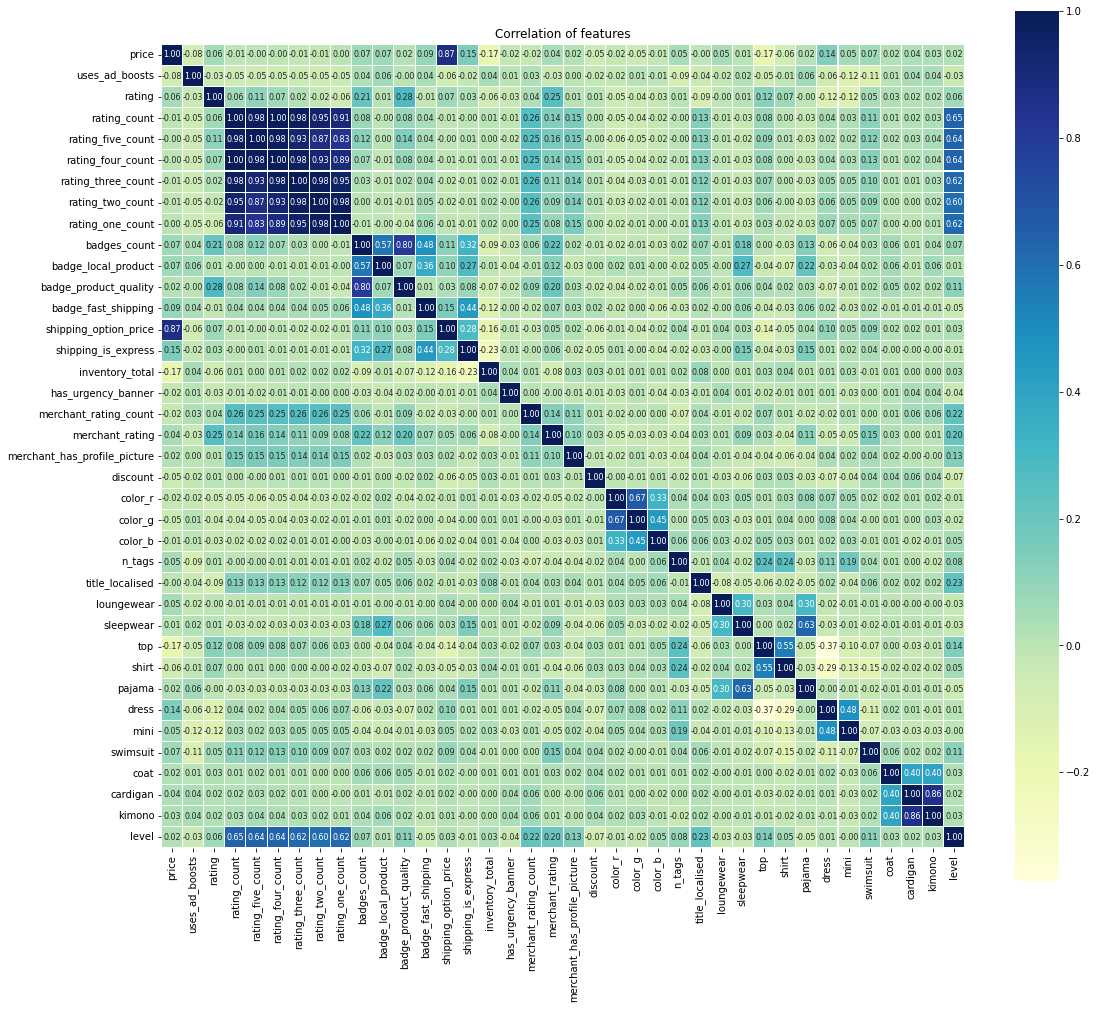

In [ ]:
all_corr = data.corr()

plt.figure(figsize = (18, 16))
sns.heatmap(all_corr,vmin=all_corr.values.min(), vmax=1,square=True,cmap="YlGnBu", linewidths=0.1, annot=True, annot_kws={"fontsize":8},fmt='.2f')  
plt.title('Correlation of features')
plt.show()

In [ ]:
#We'll deal with strong correlation between features first,to avoid multicollinearity. The threshold is set at 0.8

#From the heatmap, features related to rating have correaltion coefficients almost reaching 0.9
#Calculate vif to validate and see how many of them should be kept
vif_rating = pd.DataFrame()
vif_rating['feature'] = ['rating_count','rating_three_count','rating_four_count','rating_five_count','rating_two_count','rating_one_count']
for i in range(5):
    rating_colname = vif_rating['feature']
    rating_col = data[rating_colname[:i+2]]
    print('vif of',i+2,'features:',[vif(rating_col.values,j)for j in range(i+2)])
    
# We can see that even if only 2 features are kept, vif value is still large. So we can only pick one
# Because the weighted average of 'ragting_one/two/three/four/five_count' columns is already represent by 'rating' column, we can just keep rating_count
rating_col_drop = ['rating_three_count','rating_four_count','rating_five_count','rating_two_count','rating_one_count']
data.drop(columns = rating_col_drop,inplace = True)
data.shape

vif of 2 features: [32.14399007007624, 32.14399007007624]
vif of 3 features: [186.7674980264765, 32.25382559667377, 147.62043814915677]
vif of 4 features: [1022.9620750573733, 245.5770907740249, 151.5893171498255, 280.8164461738293]
vif of 5 features: [4185.347691127465, 269.69013141608747, 370.57618985944896, 1070.7250536743275, 379.9705393702612]
vif of 6 features: [inf, inf, inf, inf, inf, inf]


(1526, 33)

In [ ]:
#Correlation of shipping_option_price and price, badges_count and badges_product_quality,cardigan and kimono is also above 0.8
#Calculate vif to see if any of them should be removed

print('vif of shipping_option_price and price:',[vif(data[['shipping_option_price','price']].values,i)for i in range(2)])
print('vif of badges_count and badges_product_quality:',[vif(data[['badges_count','badge_product_quality']].values,i)for i in range(2)])
print('vif of cardigan and kimono:',[vif(data[['cardigan','kimono']].values,i)for i in range(2)])

#Result shows that only collinearity between shipping_option_price and price should be considered
#For price is the direct information customer can see, we will delete shipping_option_price
data.drop(columns = 'shipping_option_price', inplace = True)
data.shape

vif of shipping_option_price and price: [22.875054933220945, 22.875054933220945]
vif of badges_count and badges_product_quality: [2.965143913387906, 2.965143913387906]
vif of cardigan and kimono: [3.7692307692307696, 3.7692307692307683]


(1526, 32)

In [ ]:
#Then, we check correlation of all features and units_sold
#Correlation of other features and units_sold are a bit low
sales_corr = data.corr()
sales_corr['level'].sort_values(ascending=False)

level                           1.000000
rating_count                    0.645860
title_localised                 0.226083
merchant_rating_count           0.216667
merchant_rating                 0.202143
top                             0.142650
merchant_has_profile_picture    0.133119
badge_product_quality           0.113346
swimsuit                        0.112238
n_tags                          0.084766
badges_count                    0.074822
rating                          0.063952
shirt                           0.052420
color_b                         0.051360
inventory_total                 0.033336
kimono                          0.027594
coat                            0.025587
price                           0.022576
cardigan                        0.017813
badge_local_product             0.010935
dress                           0.005021
mini                           -0.002131
color_r                        -0.009602
shipping_is_express            -0.014248
color_g         

# Feature Selection

In [ ]:
#Because the overall corelation coefficient of other features are not high, and not distinguishing
#we will apply feature selection method to determine useful features

In [ ]:
#Split x,y data
y = data['level']
x = data.drop(columns = 'level')

In [ ]:
select = SelectKBest(score_func = mutual_info_classif, k = 'all')
select.fit(x,y)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x7f148e375680>)

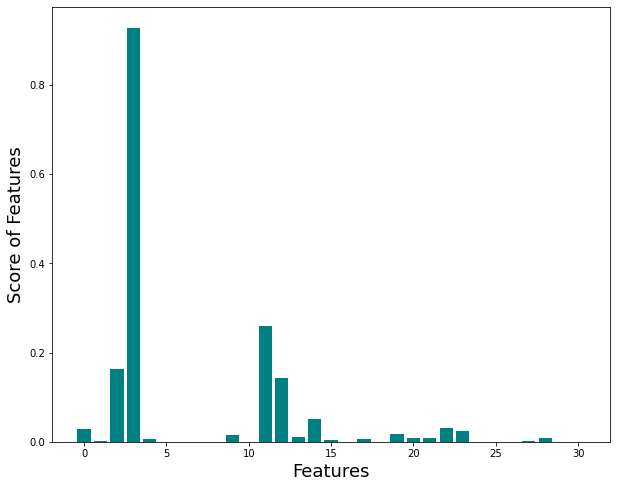

In [ ]:
fig = plt.figure(figsize = (10, 8))
plt.bar([i for i in range(len(select.scores_))], select.scores_,color="teal")
#plt.tick_params(color='white', labelcolor='white')
plt.xlabel('Features',fontsize = 18)
plt.ylabel('Score of Features',fontsize = 18)
plt.show()

In [ ]:
select_features = SelectKBest(score_func = mutual_info_classif, k = 9)
select_features.fit(x,y)

SelectKBest(k=9, score_func=<function mutual_info_classif at 0x7f148e375680>)

In [ ]:
cols = select_features.get_support(indices=True)
colss=[]
for i in cols:
    colss.append(data.columns[i])

['rating_count',
 'rating',
 'discount',
 'title_localised',
 'price',
 'badges_count',
 'n_tags',
 'top',
 'uses_ad_boosts']

In [ ]:
col_touse_n=['rating_count', 'rating', 'discount', 'title_localised','price','badges_count', 'n_tags','top','uses_ad_boosts']
data_m=data[col_touse_n]   
#data_m store x to use

In [ ]:
data_m.describe()

,rating_count,rating,discount,title_localised,price,badges_count,n_tags,top,uses_ad_boosts
count,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000
mean,915.100917,3.814777,25.851725,0.901704,8.349312,0.106815,17.417431,0.353866,0.439712
std,2008.473392,0.497746,40.831455,0.297812,3.937228,0.343167,4.100627,0.478325,0.496515
min,0.000000,1.000000,-18.200000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000
25%,27.000000,3.550000,-12.500000,1.000000,5.812500,0.000000,14.000000,0.000000,0.000000
50%,166.000000,3.850000,5.666667,1.000000,8.000000,0.000000,17.000000,0.000000,0.000000
75%,881.750000,4.100000,72.069767,1.000000,11.000000,0.000000,20.000000,1.000000,1.000000
max,20744.000000,5.000000,96.928571,1.000000,49.000000,3.000000,41.000000,1.000000,1.000000


In [ ]:
data_m.shape

(1526, 9)

# Modelling-Neural Network

In [ ]:
y = data['level']
x = data_m

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3,random_state = 1)
print('Shape of training set ', x_train.shape)
print('Shape of test set ', x_test.shape)

Shape of training set  (1068, 10)
Shape of test set  (458, 10)


In [ ]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [ ]:
mlp=MLPClassifier(solver='lbfgs',random_state=42,hidden_layer_sizes=[3,5],activation='relu',alpha=1)
mlp.fit(x_train_scaled,y_train)
print('Accuracy on training set:{:.3f}'.format(mlp.score(x_train_scaled,y_train)))
print('Accuracy on testing set:{:.3f}'.format(mlp.score(x_test_scaled,y_test)))

#Accuracy on training set:0.757  0.853  0.847  0.857
#Accuracy on testing set:0.745   0.832  0.838  0.838

Accuracy on training set:0.877
Accuracy on testing set:0.856


# Modelling-Decision Tree

In [ ]:
classifier_DTC = DecisionTreeClassifier(random_state = 66,max_leaf_nodes = 8)
classifier_DTC.fit(x_train, y_train)

y_train_DTC = classifier_DTC.predict(x_train)
y_test_DTC = classifier_DTC.predict(x_test)

print('Accuracy on training set:{:.3f}'.format(accuracy_score(y_train, y_train_DTC)))
print('Accuracy on testing set:{:.3f}'.format(accuracy_score(y_test, y_test_DTC)))

# Accuracy on training set:0.716  0.86
# Accuracy on testing set:0.699  0.854

Accuracy on training set:0.860
Accuracy on testing set:0.854


# Modelling-Random Forest

In [ ]:
classifier_RFC = RandomForestClassifier(random_state = 1,n_estimators=30, max_leaf_nodes = 50)
classifier_RFC.fit(x_train, y_train)

y_train_RFC = classifier_RFC.predict(x_train)
y_test_RFC = classifier_RFC.predict(x_test)
print('Accuracy on training set:{:.3f}'.format(accuracy_score(y_train, y_train_RFC)))
print('Accuracy on testing set:{:.3f}'.format(accuracy_score(y_test, y_test_RFC)))
#n_estimators=30, max_leaf_nodes = 50
#Accuracy on training set:0.835  0.994  0.911
#Accuracy on testing set:0.666   0.972  0.858

Accuracy on training set:0.921
Accuracy on testing set:0.858


In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
#define par
n_estimators = [int(x) for x in np.linspace(start=5, stop=50, num=15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

#Best paramters: {'n_estimators': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False})

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True): #Accuracy Report
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False: #test data
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
#####evaluate model#####
print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)
#Accuracy on training set:99.81%
#Accuracy on testing set:72.05%

# Modelling - Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier_GBC = GradientBoostingClassifier(random_state = 3)
classifier_GBC.fit(x_train, y_train)

y_pred_GBC = classifier_GBC.predict(x_test)
accuracy_score(y_test, y_pred_GBC)


0.8493449781659389

In [ ]:
print_score(classifier_GBC, x_train, y_train, x_test, y_test, train=True)
print_score(classifier_GBC, x_train, y_train, x_test, y_test, train=False)
#Accuracy on training set:98.5%
#Accuracy on testing set:73.36%

Train Result:
Accuracy Score: 98.13%
_______________________________________________
CLASSIFICATION REPORT:
                    1           2  ...    macro avg  weighted avg
precision    0.978673    0.978648  ...     0.984735      0.981316
recall       0.997585    0.961538  ...     0.979023      0.981273
f1-score     0.988038    0.970018  ...     0.981809      0.981229
support    414.000000  286.000000  ...  1068.000000   1068.000000

[4 rows x 7 columns]
_______________________________________________
Confusion Matrix: 
 [[413   1   0   0]
 [  8 275   3   0]
 [  1   5 267   0]
 [  0   0   2  93]]

Test Result:
Accuracy Score: 84.93%
_______________________________________________
CLASSIFICATION REPORT:
                    1           2  ...   macro avg  weighted avg
precision    0.911765    0.788462  ...    0.832366      0.845958
recall       0.973822    0.700855  ...    0.815999      0.849345
f1-score     0.941772    0.742081  ...    0.823047      0.846493
support    191.000000  117.

# Modelling- XGboosting

In [ ]:
from xgboost import XGBClassifier
classifier_XGB = XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.5, colsample_bytree=0.5, subsample=0.5)
classifier_XGB.fit(x_train, y_train)

y_train_XGB = classifier_XGB.predict(x_train)
y_pred_XGB = classifier_XGB.predict(x_test)

print('Accuracy on training set:{:.3f}'.format(accuracy_score(y_train, y_train_XGB)))
print('Accuracy on testing set:{:.3f}'.format(accuracy_score(y_test, y_pred_XGB)))

#Accuracy on training set:0.839
#Accuracy on testing set:0.723
######################################################################################################################################

Accuracy on training set:0.914
Accuracy on testing set:0.867


# Modelling- KNN

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

classifier_KNN = KNeighborsClassifier(n_neighbors = 25)
classifier_KNN.fit(x_train_scaled, y_train)

y_train_KNN = classifier_KNN.predict(x_train_scaled)
y_pred_KNN = classifier_KNN.predict(x_test_scaled)

print('Accuracy on training set:{:.3f}'.format(accuracy_score(y_train, y_train_KNN)))
print('Accuracy on testing set:{:.3f}'.format(accuracy_score(y_test, y_pred_KNN)))

#Accuracy on training set:0.738
#Accuracy on testing set:0.718

Accuracy on training set:0.601
Accuracy on testing set:0.546


# Cross Validation Score

In [ ]:
from sklearn.model_selection import cross_val_score
#for non-scaling models

classifiers = [classifier_DTC,
        classifier_RFC,
        classifier_XGB]
classifiers_names = ['Decision Tree',
           'Random Forest',
           'XG Boost']
accuracy_mean = []

for cl in classifiers :
    accuracies = cross_val_score(estimator = cl, 
                                 X = x_train, 
                                 y = y_train, 
                                 cv = 6) #交叉验证评分
    accuracy_mean.append(accuracies.mean()*100)

    
accuracy_df1 = pd.DataFrame({'Classifier': classifiers_names,'Accuracy Mean': accuracy_mean})

In [ ]:
#for scaled models 

classifiers = [mlp,
        classifier_KNN]
classifiers_names = ['Neural Newwork',
           'KNeighborsClassifier']
accuracy_mean = []

for cl in classifiers :
    accuracies = cross_val_score(estimator = cl, 
                                 X = x_train_scaled, 
                                 y = y_train, 
                                 cv = 6) #交叉验证评分
    accuracy_mean.append(accuracies.mean()*100)

    
accuracy_df2 = pd.DataFrame({'Classifier': classifiers_names,'Accuracy Mean': accuracy_mean})
accuracy_df=pd.concat([accuracy_df1,accuracy_df2],axis=0)
accuracy_df.sort_values('Accuracy Mean',ascending=False)

,Classifier,Accuracy Mean
2,XG Boost,85.205993
0,Neural Newwork,84.737828
1,Random Forest,84.082397
0,Decision Tree,83.895131
1,KNeighborsClassifier,54.868914


In [ ]:
#XGBoost
#Accuracy on training set:0.839
#Accuracy on testing set:0.723
#Accuracy of Cross validation: 0.713